# ACOUSTIC MONITORING OF ECOSYSTEMS

Ecosystems contain vast amounts of data that tell a lot about what is happening in them. Using acoustic monitoring we can monitor wildlife remotely and continously. Animals produce sounds that we can use to identify them without having to observe them physically. Birds, especially, vocalize a lot and we can use them in studying our ecosystems. In this notebook, we will see how we achieve acoustic classification of birds. We will classify three species of birds common in Kenya. The species are:
1. Hartlaub's turaco
2. Tropical boubou
3. Grey-backed camaroptera

We will use local audio data and data from [Xeno-canto](https://www.xeno-canto.org/) for this task. 



In [1]:
# import necessary libraries
import numpy as np
import librosa 
import os
import librosa.display
import IPython.display
import csv
import matplotlib.pyplot as plt
import warnings
import configparser
import random

In [2]:
warnings.filterwarnings('ignore')

# Get parameters from configuration file
config = configparser.ConfigParser()
config.read('files/parameters-birds.ini')

win_len_ms = int(config['audio']['win_len_ms'])
overlap = float(config['audio']['overlap'])
sampling_rate = int(config['audio']['sampling_rate'])
duration = float(config['neural-net']['input_duration_s'])
rnd_seed = int(config['neural-net']['seed'])
num_mels = int(config['baseline']['num_mels'])


# Derive audio processing values
win_len = int((win_len_ms * sampling_rate) / 1000)
hop_len = int(win_len * (1 - overlap))
nfft = int(2 ** np.ceil(np.log2(win_len)))
num_frame = int((0.5 * duration * sampling_rate) / hop_len)

Let's load and play 3 seconds of sample recordings for the three species:

In [3]:
# Hartlaub's turaco
y, _ = librosa.load('audio-samples/bird-samples/hartlaub\'s turaco.wav', sr=sampling_rate)
IPython.display.Audio(y[: int(sampling_rate * 3)], rate=sampling_rate)

In [4]:
# Tropical boubou
y, _ = librosa.load('audio-samples/bird-samples/tropical-boubou.wav', sr=sampling_rate)
IPython.display.Audio(y[: int(sampling_rate * 3)], rate=sampling_rate)

In [5]:
# Grey-backed camaropteraabs
y, _ = librosa.load('audio-samples/bird-samples/grey-backed camaroptera.wav', sr=sampling_rate)
IPython.display.Audio(y[: int(sampling_rate * 3)], rate=sampling_rate)

The samples sound differently to our ears. Anyone with the experience of telling the three species from their sounds can easily identify them from listening to the samples we have just played. We intend to enable a digital computer to mimick this behaviour and identify different bird species from their sounds. This will be achieved using digital signal processing and machine learning.

## Acoustic Classification of Birds
Acoustic classification of birds is an interesting field that can find its use in ecosystems conservation, ornithology and also for bird watchers. Manual classification of acoustic data is cumbersome and so we opt for automatic acoustic classification. Automatic acoustic classification of birds is, however, faced by the following challenges:
1. Limited annotated data per species
2. Background noise
3. Variable length of recordings
4. Multiple birds singing simultaneously

### DSAIL Acoustic Sensor
![Segmentation](files/sensor-setup.png)

![Segmentation](files/labeled-power-board.png)

![Segmentation](files/sensor-deployed-&-labels.png)


To achieve reasonble results, we need to manipulate the data. This is acheived using data preprocessing and data augmentation.

### Data preprocessing
In this task, we separated audio files into signal into signal part where bird sounds are audible and noise part where there are no bird sounds (background noise may be present in this part). The separation of the audio file into signal and noise parts is done as described in **Sprengel, E., Jaggi, M., Kilcher, Y., & Hofmann, T. (2016). Audio based bird species identification using deep learning techniques**.

#### Signal extraction
This acheived by computing the spectrogram of an audio file and then selecting pixels that have a value greater than a given threshold and treating them as corresponding to signal.
#### Noise extraction
This was acheived by selecting the pixel values of the spectrogram that are less than a given threshold and treating them as corresponding to noise.

![Segmentation](files/segmentation.png)


## Features Extraction

We will extract features from the recordings and use them as inputs to our machine learning models. We will use melspectrograms for this task. The melspectrograms are obtained by applying 40 mel filters to the spectrograms of the recordings. 

Let's compute the melspectrograms of the recordings of the three species we played at the beginning of this notebook:

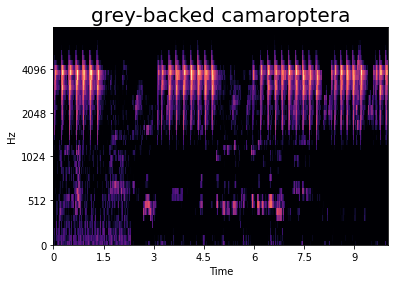

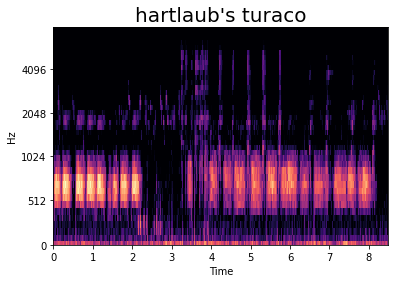

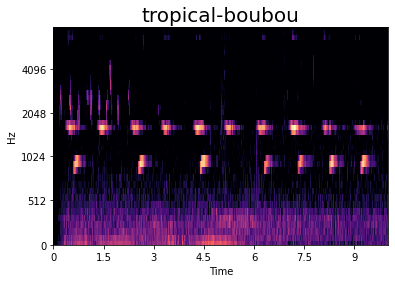

In [6]:
mels_dir = 'sample-melspects/'
if not os.path.exists(mels_dir):
    os.mkdir(mels_dir)

samples_dir = './audio-samples/bird-samples'
files = os.listdir(samples_dir)

for file in files:
    y, _ = librosa.load(os.path.join(samples_dir, file), sr=sampling_rate)



    melspect = librosa.feature.melspectrogram(y[: int(10 * sampling_rate)],
                                            sr=sampling_rate,
                                            n_fft=nfft,
                                            hop_length=hop_len,
                                            win_length=win_len,
                                            window='hamming',
                                            n_mels=num_mels)



    np.save(mels_dir + file.split('.')[0] + '.npy', melspect)


    plt.figure()
    librosa.display.specshow(librosa.amplitude_to_db(melspect, ref=np.max),
                            hop_length=hop_len,
                            sr=sampling_rate,
                            y_axis='mel',
                            x_axis='time')
    plt.title(file.split('.')[0], fontsize=20)

We can visually observe that the melspectrograms of the three species are different. This is because of difference in frequency components of sounds of birds belonging to different species.  We will be using this uniqueness to identify different species of birds from their sound.

### Audio padding
For our classification models, we need fixed size inputs. However, before and after signal and noise separation, some files have shorter lengths than the required threshold length. To ensure these files are of at least threshold-length long, we will pad them with noise. Padding a signal with noise helps in developing the model by exposing it to the noise it will encounter in the field. 
![Noise padding](files/noise-padding.png)

### Features Generation

The features that were fed to machine learning models are the mean and the variance of the frequency channels. We split the melspectrograms into chunks of equal length. Therefore, from one audio data, we obtain multiple features that we feed to machine learning models. This helps solve the problem of limited data per species and that of variable length of recordings.

Let's load the melspectrograms of the three species and perform these operations: 

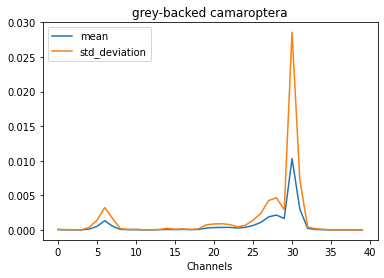

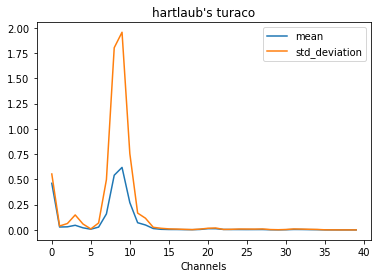

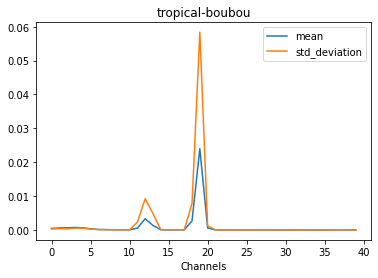

In [7]:
files = [file for file in os.listdir(mels_dir) if file.endswith('.npy')]

for file in files:
    melspect = np.load(os.path.join(mels_dir, file))
    if melspect.shape[1] > 2 * num_frame + 1: #process audio block of length 3 seconds
        indx = random.randint(num_frame, melspect.shape[1] - num_frame - 1)
        current_feature = melspect[:, indx - num_frame: indx + num_frame + 1]
        plt.figure()
        plt.plot(np.mean(current_feature, axis=1), label='mean')
        plt.plot(np.std(current_feature, axis=1),  label='std_deviation')
        plt.xlabel('Channels')
        plt.title(file.split('.')[0])
        plt.legend()

## Baseline Models
A baseline model can be defined as a simple model that provides reasonable results on a task and requires not much time and expertise to develop. Baseline models helps put the more complex models into context in terms of accuracy. The results obtained from a baseline model should guide us in making the choice of complex model to use. In this classification task, we will use `Linear Support Vector Classifier`, `Support Vector Classifier`, `Multilayer Perceptron Classifier` and `Random Forests Classifiers` as our baseline models.

In [8]:
#import necessary libraries
import pickle
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import features_generation as fg
import ipywidgets as wg
import time
import pandas as pd

In [9]:
def all_summary_features(feature, filename, annotation_dict, num_frame):
    """ Splits melspectrograms into chunks. 
    Args:feature- melspectrogram
         filename- file name of the melspectrogram
         annotation_dict- a dictionary containing file names and labels
         fmean- mean of the entire melspectrograms dataset channels
         fstd- standard deviation of the entire melspectrograms dataset channels
         num_frame- number of frames.
         
    Returns an array of features and their labels
    """

    file_features = []
    file_labels = []

    if feature.shape[1] > 2 * num_frame + 1:

        for indx in range(num_frame, feature.shape[1] - num_frame - 1, num_frame):

            current_feature = feature[:, indx - num_frame: indx + num_frame + 1]


            file_features.append(np.concatenate((np.mean(current_feature, axis=1),
                                            np.std(current_feature, axis=1))))


            file_labels.append(annotation_dict[filename])

    return np.array(file_features), np.array(file_labels)


def train_val_split(filelist, annotation_dict):
    """Returns training and validation files and labels
    Args:filelist- list of melpectrograms paths
         annotation_dict- a dictionary of features and their labels"""
    
    all_features = np.array([])
    all_labels = np.array([])
    
    for filename in filelist:
        file_labels = []

        feature = np.load(filename)
        feature = np.log(feature + 1e-8)
        file_features, file_labels = all_summary_features(feature,
                                                            filename,
                                                            annotation_dict,
                                                            num_frame)
        
        if all_features.size:
            all_features = np.vstack((all_features, file_features))
        else:
            all_features = file_features
        all_labels = np.concatenate((all_labels, file_labels))
        
    X_train, X_val, y_train, y_val = train_test_split(all_features, all_labels, test_size=0.3, random_state=42)
    
    return X_train, X_val, y_train, y_val   


def train_models(clf, model, models_dir, species, X_train, X_val, y_train, y_val):
    """Trains a classifier
    Args: clf- classifier
          model- name of model
          models_dir- directory to save models
          species- list containing species names
          X_train- training data
          X_val- validation data
          y_train- training labels
          y_val- validation labels
    """
    
    print('Training an {} classifier'.format(model))
    print('\n')

    start = time.time()

    clf.fit(X_train, y_train)

    end = time.time()

    path = os.path.join(models_dir, model + '.pickle') #path to save models
    pickle.dump(clf, open(path, 'wb'))


    species_f1_score = f1_score(y_val, clf.predict(X_val), average=None)
    species_precision_score = precision_score(y_val, clf.predict(X_val), average=None)
    species_recall_score = recall_score(y_val, clf.predict(X_val), average=None)
    df_species_metrics = pd.DataFrame(list(zip(species,
                                               species_precision_score,
                                               species_recall_score,
                                               species_f1_score)),
                                      columns=['Species', 'Precision', 'Recall', 'F1 Score'])
    df_species_metrics = df_species_metrics.sort_values(['F1 Score'], ascending=False)
    df_species_metrics = df_species_metrics.reset_index(drop=True)

    time_spent = round((end - start) / 60, 2)

    print('Time spent is:', time_spent, 'minutes')

    print('Mean F1 score:', np.mean(species_f1_score))
    print(df_species_metrics.round(2))
    print('\n')
    
    
def model_test(index):
    """Test trained models
    Args:index- index of model in model list
         """
    
    models_dir = 'models'
    
    models = ['svm', 'rf', 'svm-rbf', 'mlp', 'null']
    
    model = models[index]
    
    if model != 'null':
        #load a pretrained model and use it to predict a sample test data
        tree = next(os.walk('audio-samples/birds-test-data/'))

        dir_paths = [os.path.join(tree[0], sub_dir) for sub_dir in tree[1]]

        filelist = []
        for sub_dir in dir_paths:
            files = os.listdir(sub_dir)
            for file in files:
                filelist.append(os.path.join(sub_dir, file).replace('\\', '/'))

        file_indx = random.randint(0, len(filelist) - 1)
        file = filelist[file_indx]

        target = file.split('/')[2]

        clf = pickle.load(open(os.path.join(models_dir, model + '.pickle'), 'rb'))

        audio,_ = librosa.load(file, sr=sampling_rate)
        
        IPython.display.Audio(audio, rate=sampling_rate)
        
        noise_dir = 'audio-samples/noise'
        
        feature = fg.features_extraction(audio,
                                     nfft,
                                     hop_len,
                                     noise_dir,
                                     sampling_rate,
                                     duration,
                                     win_len,
                                     hop_len,
                                     num_mels)

        feature = np.log(feature + 1e-8)

        features = np.concatenate((np.mean(feature, axis=1),
                                                np.std(feature, axis=1))).reshape(1, -1)


        species  = ['grey-backed camaroptera', 'hartlaub\'s turaco', 'tropical boubou']


        predicted = clf.predict(features)


        predicted = species[int(predicted[0])]

        print('Predicted species:',  predicted, '\n', 'Expected species:', target)
        IPython.display.Audio(audio, rate=sampling_rate)

        
def main():
    
    models_dir = './models'
    annotation_csv = 'files/labels.csv'
    mels_dir = './data/birds-melspectrograms/'
    
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    labels = []
    df_annotation = pd.read_csv(annotation_csv)

    species = list(set(df_annotation['label']))
    species.sort()
    species_dict = dict(zip(species, range(len(species))))
    species_dict
    for file_species in list(df_annotation['label']):
        labels.append(species_dict[file_species])   
    filelist = list(df_annotation.name)
    for indx, filename in enumerate(filelist):
        filelist[indx] = os.path.join(mels_dir, filename)

    annotation_dict = dict(zip(filelist, labels))
    
    df = pd.read_csv('files/models_params.csv')

    models = ['svm', 'rf', 'svm-rbf', 'mlp']
    
    X_train, X_val, y_train, y_val = train_val_split(filelist, annotation_dict)
    
    
    for model in models:
        param = int(df.best_param[df[df['model'] == model].index.values].item())
        
        if model == 'svm':
            clf = LinearSVC(C=param, random_state=0, tol=1e-5, multi_class='crammer_singer', max_iter=10000)
            
        elif model == 'svm-rbf':
            clf = SVC(gamma='auto', C=param, probability=True)
            
        elif model == 'mlp':
            clf = MLPClassifier(hidden_layer_sizes=param, random_state=1, max_iter=10000)
        elif model == 'rf':
            clf = RandomForestClassifier(n_estimators=param, max_depth=None, random_state=0)
            
             
            
        train_models(clf, model, models_dir, species, X_train, X_val, y_train, y_val)
        

In [10]:
#Run this cell to train the classifiers
if __name__ == '__main__':
    main()

Training an svm classifier


Time spent is: 0.93 minutes
Mean F1 score: 0.5970058955092856
                   Species  Precision  Recall  F1 Score
0  grey-backed camaroptera       0.96    0.61      0.75
1          tropical boubou       0.68    0.83      0.75
2        hartlaub's turaco       0.19    0.68      0.29


Training an rf classifier


Time spent is: 0.05 minutes
Mean F1 score: 0.9714441710645273
                   Species  Precision  Recall  F1 Score
0  grey-backed camaroptera       0.98    1.00      0.99
1          tropical boubou       0.98    0.97      0.98
2        hartlaub's turaco       1.00    0.90      0.95


Training an svm-rbf classifier


Time spent is: 0.03 minutes
Mean F1 score: 0.9863066136169456
                   Species  Precision  Recall  F1 Score
0  grey-backed camaroptera       1.00    1.00      1.00
1          tropical boubou       0.99    0.99      0.99
2        hartlaub's turaco       1.00    0.94      0.97


Training an mlp classifier


Time spent is: 0.

Run the cell below to test the trained models. Use the dropdown to select the model to test and observe the predicted and the expected species. Select a new model randomly and make an observation.

In [11]:
drop_down_display = [('Choose Model', -1), ('svm', 0), ('rf', 1), ('svm-rbf', 2), ('mlp', 3)]


drop_down = wg.Dropdown(options=drop_down_display,
                           description='Models:',
                           disabled=False)

wg.interact(model_test, index=drop_down)

interactive(children=(Dropdown(description='Models:', options=(('Choose Model', -1), ('svm', 0), ('rf', 1), ('…

<function __main__.model_test(index)>